**Earnings Quality and Fundamental Analysis - Final Project - Columbia Business School Spring 2025**

In [3]:
using CSV, DataFrames, Dates

# === Load the dataset ===
df = CSV.read("financial_data.csv", DataFrame)

Row,Company Name,Sector,Industry,Ticker,Report Date,Currency,Fiscal Year,Fiscal Period,Publish Date,Restated Date,Shares (Basic),Shares (Diluted),Revenue,Cost of Revenue,Gross Profit,Operating Expenses,"Selling, General & Administrative",Operating Income (Loss),Non-Operating Income (Loss),"Interest Expense, Net","Pretax Income (Loss), Adj.",Pretax Income (Loss),"Income Tax (Expense) Benefit, Net",Income (Loss) from Continuing Operations,Net Income,Net Income (Common),Net Income/Starting Line,Non-Cash Items,Change in Working Capital,Net Cash from Operating Activities,Change in Fixed Assets & Intangibles,Net Cash from Investing Activities,Dividends Paid,Cash from (Repayment of) Debt,Cash from (Repurchase of) Equity,Net Cash from Financing Activities,Net Change in Cash,"Cash, Cash Equivalents & Short Term Investments",Cash & Cash Equivalents,Accounts & Notes Receivable,"Accounts Receivable, Net",Inventories,Other Short Term Assets,Misc. Short Term Assets,Total Current Assets,"Property, Plant & Equipment, Net",Other Long Term Assets,Goodwill,Misc. Long Term Assets,Total Noncurrent Assets,Total Assets,Payables & Accruals,Accounts Payable,Other Payables & Accruals,Short Term Debt,Other Short Term Liabilities,Total Current Liabilities,Long Term Debt,Other Long Term Liabilities,Misc. Long Term Liabilities,Total Noncurrent Liabilities,Total Liabilities,Share Capital & Additional Paid-In Capital,Retained Earnings,Other Equity,Equity Before Minority Interest,Total Equity,Total Liabilities & Equity,EBITDA,Total Debt,Free Cash Flow,Gross Profit Margin,Operating Margin,Net Profit Margin,Return on Equity,Return on Assets,Free Cash Flow to Net Income,Current Ratio,Liabilities to Equity Ratio,Debt Ratio,"Earnings Per Share, Basic","Earnings Per Share, Diluted",Sales Per Share,Equity Per Share,Free Cash Flow Per Share,Dividends Per Share,Piotroski F-Score,Return On Invested Capital,Cash Return On Invested Capital,Dividend Payout Ratio,Net Debt / EBITDA,Net Debt / EBIT,Shares (Basic) change from last quarter,Shares (Basic) change from last 2 quarters,Shares (Basic) change from last 3 quarters,Shares (Basic) change from last 4 quarters,Shares (Diluted) change from last quarter,Shares (Diluted) change from last 2 quarters,Shares (Diluted) change from last 3 quarters,Shares (Diluted) change from last 4 quarters,⋯
,String31,String31,String31,String7,String15,String3,Int64,String3,String15,String15,Int64,Int64,Float64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Float64,Int64,Float64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Float64,Float64,Float64,Int64,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Float64,Float64,Float64,Float64,Float64,Int64,Float64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,⋯
1,APPLE INC,Technology,Computer Hardware,AAPL,6/30/2001,USD,2001,Q3,8/13/2001,8/13/2001,24208660000,24900176000,1.475e9,-1041000000,434000000,-392000000,-281000000,42000000,45000000,0,87000000,87000000,-26000000,61000000,61000000,61000000,61000000,26000000,-146000000,-33000000,-30000000,10000000,-3216536585,1638560000,6000000,6000000,-17000000,4.218e9,2121000000,5.98e8,598000000,1.9e7,4.13e8,2.4e8,5.248e9,3.47e8,4.76e8,2653746835,4.76e8,8.23e8,6.071e9,1614000000,847000000,767000000,6.33877e9,1.96989e10,1.614e9,3.17e8,2.82e8,2.21446e10,5.99e8,2.213e9,1673000000,2.194e9,-9.0e6,3.858e9,3.858e9,6.071e9,68000000,3.17e8,-82000000,0.29424,0.02847,0.04136,0.01581,0.01005,-1.34426,3.25155,0.57361,0.05222,0.00252,0.00245,0.06093,0.15936,-0.00339,0.16282,5.59756,0.01369,-0.0184,0.251461,-57.3676,-92.8809,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,⋯
2,APPLE INC,Technology,Computer Hardware,AAPL,9/30/2001,USD,2001,Q4,12/21/2001,12/21/2001,2

In [5]:
# === Parse 'Report Date' safely ===
if eltype(df[!, "Report Date"]) != Date
    df[!, "Report Date"] = Date.(df[!, "Report Date"], dateformat"m/d/y")
end

# === Sort by Ticker and Report Date ===
sort!(df, ["Ticker", "Report Date"])

Row,Company Name,Sector,Industry,Ticker,Report Date,Currency,Fiscal Year,Fiscal Period,Publish Date,Restated Date,Shares (Basic),Shares (Diluted),Revenue,Cost of Revenue,Gross Profit,Operating Expenses,"Selling, General & Administrative",Operating Income (Loss),Non-Operating Income (Loss),"Interest Expense, Net","Pretax Income (Loss), Adj.",Pretax Income (Loss),"Income Tax (Expense) Benefit, Net",Income (Loss) from Continuing Operations,Net Income,Net Income (Common),Net Income/Starting Line,Non-Cash Items,Change in Working Capital,Net Cash from Operating Activities,Change in Fixed Assets & Intangibles,Net Cash from Investing Activities,Dividends Paid,Cash from (Repayment of) Debt,Cash from (Repurchase of) Equity,Net Cash from Financing Activities,Net Change in Cash,"Cash, Cash Equivalents & Short Term Investments",Cash & Cash Equivalents,Accounts & Notes Receivable,"Accounts Receivable, Net",Inventories,Other Short Term Assets,Misc. Short Term Assets,Total Current Assets,"Property, Plant & Equipment, Net",Other Long Term Assets,Goodwill,Misc. Long Term Assets,Total Noncurrent Assets,Total Assets,Payables & Accruals,Accounts Payable,Other Payables & Accruals,Short Term Debt,Other Short Term Liabilities,Total Current Liabilities,Long Term Debt,Other Long Term Liabilities,Misc. Long Term Liabilities,Total Noncurrent Liabilities,Total Liabilities,Share Capital & Additional Paid-In Capital,Retained Earnings,Other Equity,Equity Before Minority Interest,Total Equity,Total Liabilities & Equity,EBITDA,Total Debt,Free Cash Flow,Gross Profit Margin,Operating Margin,Net Profit Margin,Return on Equity,Return on Assets,Free Cash Flow to Net Income,Current Ratio,Liabilities to Equity Ratio,Debt Ratio,"Earnings Per Share, Basic","Earnings Per Share, Diluted",Sales Per Share,Equity Per Share,Free Cash Flow Per Share,Dividends Per Share,Piotroski F-Score,Return On Invested Capital,Cash Return On Invested Capital,Dividend Payout Ratio,Net Debt / EBITDA,Net Debt / EBIT,Shares (Basic) change from last quarter,Shares (Basic) change from last 2 quarters,Shares (Basic) change from last 3 quarters,Shares (Basic) change from last 4 quarters,Shares (Diluted) change from last quarter,Shares (Diluted) change from last 2 quarters,Shares (Diluted) change from last 3 quarters,Shares (Diluted) change from last 4 quarters,⋯
,String31,String31,String31,String7,Date,String3,Int64,String3,String15,String15,Int64,Int64,Float64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Float64,Int64,Float64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Float64,Float64,Float64,Int64,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Float64,Float64,Float64,Float64,Float64,Int64,Float64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,⋯
1,APPLE INC,Technology,Computer Hardware,AAPL,2001-06-30,USD,2001,Q3,8/13/2001,8/13/2001,24208660000,24900176000,1.475e9,-1041000000,434000000,-392000000,-281000000,42000000,45000000,0,87000000,87000000,-26000000,61000000,61000000,61000000,61000000,26000000,-146000000,-33000000,-30000000,10000000,-3216536585,1638560000,6000000,6000000,-17000000,4.218e9,2121000000,5.98e8,598000000,1.9e7,4.13e8,2.4e8,5.248e9,3.47e8,4.76e8,2653746835,4.76e8,8.23e8,6.071e9,1614000000,847000000,767000000,6.33877e9,1.96989e10,1.614e9,3.17e8,2.82e8,2.21446e10,5.99e8,2.213e9,1673000000,2.194e9,-9.0e6,3.858e9,3.858e9,6.071e9,68000000,3.17e8,-82000000,0.29424,0.02847,0.04136,0.01581,0.01005,-1.34426,3.25155,0.57361,0.05222,0.00252,0.00245,0.06093,0.15936,-0.00339,0.16282,5.59756,0.01369,-0.0184,0.251461,-57.3676,-92.8809,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,⋯
2,APPLE INC,Technology,Computer Hardware,AAPL,2001-09-30,USD,2001,Q4,12/21/2001,12/21/2001,242

In [7]:
# === Infer Depreciation ===
df[!, "Depreciation"] = df[!, "Operating Expenses"] .- df[!, "Selling, General & Administrative"]

462-element Vector{Int64}:
   -111000000
   -116000000
   -113000000
   -111000000
   -106000000
   -116000000
   -121000000
   -119000000
   -120000000
   -111000000
   -119000000
   -123000000
   -125000000
            ⋮
  -5529000000
  -5487000000
  -6376000000
  -5401000000
  -5443000000
 -31279000000
  -5546000000
  -5290000000
  -5326000000
  -6285000000
  -9164000000
  -4857000000

In [9]:
function add_lagged!(df::DataFrame, col::String)
    prev_col = "$(col)_prev"
    T = eltype(df[!, col])
    df[!, prev_col] = Vector{Union{Missing, T}}(missing, nrow(df))
    for ticker in unique(df[!, "Ticker"])
        inds = findall(df[!, "Ticker"] .== ticker)
        df[inds, prev_col] = [missing; df[inds[1:end-1], col]]
    end
end

add_lagged! (generic function with 1 method)

In [11]:
# === List of columns needed and lag them ===
cols_needed = [
    "Revenue",
    "Accounts Receivable, Net",
    "Gross Profit",
    "Total Assets",
    "Total Current Assets",
    "Property, Plant & Equipment, Net",
    "Selling, General & Administrative",
    "Total Debt",
    "Net Income",
    "Net Cash from Operating Activities",
    "Depreciation"
]

foreach(col -> add_lagged!(df, col), cols_needed)

# === Drop rows with any missing values in required columns and their lagged versions ===
required_columns = vcat(cols_needed, ["$(col)_prev" for col in cols_needed])
dropmissing!(df, required_columns)

# === Calculate Beneish Variables ===
df[!, "DSRI"] = (df[!, "Accounts Receivable, Net"] ./ df[!, "Revenue"]) ./ 
                (df[!, "Accounts Receivable, Net_prev"] ./ df[!, "Revenue_prev"])

df[!, "GMI"] = ((df[!, "Revenue_prev"] .- df[!, "Gross Profit_prev"]) ./ df[!, "Revenue_prev"]) ./ 
              ((df[!, "Revenue"] .- df[!, "Gross Profit"]) ./ df[!, "Revenue"])

df[!, "AQI"] = ((df[!, "Total Assets"] .- df[!, "Total Current Assets"] .- df[!, "Property, Plant & Equipment, Net"]) ./ df[!, "Total Assets"]) ./ 
              ((df[!, "Total Assets_prev"] .- df[!, "Total Current Assets_prev"] .- df[!, "Property, Plant & Equipment, Net_prev"]) ./ df[!, "Total Assets_prev"])

df[!, "SGI"] = df[!, "Revenue"] ./ df[!, "Revenue_prev"]

df[!, "DEPI"] = (df[!, "Property, Plant & Equipment, Net_prev"] .+ df[!, "Depreciation_prev"]) ./ df[!, "Depreciation_prev"] ./ 
                ((df[!, "Property, Plant & Equipment, Net"] .+ df[!, "Depreciation"]) ./ df[!, "Depreciation"])

df[!, "SGAI"] = (df[!, "Selling, General & Administrative"] ./ df[!, "Revenue"]) ./ 
                (df[!, "Selling, General & Administrative_prev"] ./ df[!, "Revenue_prev"])

df[!, "LVGI"] = (df[!, "Total Debt"] ./ df[!, "Total Assets"]) ./ 
                (df[!, "Total Debt_prev"] ./ df[!, "Total Assets_prev"])

df[!, "TATA"] = (df[!, "Net Income"] .- df[!, "Net Cash from Operating Activities"]) ./ df[!, "Total Assets"]

# === Compute M-Score ===
df[!, "MScore"] = -4.84 .+ 0.92 .* df[!, "DSRI"] .+ 0.528 .* df[!, "GMI"] .+ 0.404 .* df[!, "AQI"] .+ 
                  0.892 .* df[!, "SGI"] .+ 0.115 .* df[!, "DEPI"] .- 0.172 .* df[!, "SGAI"] .+ 
                  4.679 .* df[!, "TATA"] .- 0.327 .* df[!, "LVGI"]

# === Flag potential manipulators ===
df[!, "Manipulator"] = df[!, "MScore"] .> -2.22

# === Final result DataFrame ===
result = df[:, [
    "Ticker", "Report Date", "MScore", "Manipulator",
    "DSRI", "GMI", "AQI", "SGI", "DEPI", "SGAI", "LVGI", "TATA"
]]

# === Preview ===
first(result, 10)

Row,Ticker,Report Date,MScore,Manipulator,DSRI,GMI,AQI,SGI,DEPI,SGAI,LVGI,TATA
,String7,Date,Float64,Bool,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,AAPL,2001-09-30,-3.02741,false,0.7927,1.01022,0.665142,0.983051,0.550515,0.97018,1.0083,-0.0347118
2,AAPL,2001-12-31,-2.48373,false,1.12696,1.00798,0.867612,0.948276,0.948726,1.13718,0.977297,-0.000653381
3,AAPL,2002-03-31,-2.22304,false,1.18937,0.954117,0.927935,1.08727,0.949282,0.859266,0.96492,0.00606641
4,AAPL,2002-06-30,-2.47715,false,1.01694,1.00005,0.987822,0.955853,0.941115,1.05394,1.01139,0.0109646
5,AAPL,2002-09-30,-2.62641,false,0.893799,0.986977,1.1064,1.0098,1.04667,1.01942,0.999206,-0.0204827
6,AAPL,2002-12-31,-2.3469,false,0.862316,1.01627,0.97334,1.0201,1.08836,1.04682,0.0,-0.0181847
7,AAPL,2003-03-31,-Inf,false,0.987926,1.01057,0.964418,1.00204,0.952,1.0013,Inf,-0.0132055
8,AAPL,2003-06-30,-2.35932,false,1.10217,0.991193,0.922702,1.04746,0.971487,0.95151,0.978022,0.00170781
9,AAPL,2003-09-30,-2.21968,true,1.21491,0.984834,0.956197,1.11003,0.860349,0.946069,0.935885,-0.00513573


In [13]:
function clean_inconsistent_rows!(df::DataFrame, cols::Vector{String})
    # Loop through each column and filter out rows with bad values
    for col in cols
        df = filter(row -> isfinite(row[col]) && !ismissing(row[col]), df)
    end
    return df
end

clean_inconsistent_rows! (generic function with 1 method)

In [15]:
# Define which columns to check for weird values
beneish_cols = [
    "DSRI", "GMI", "AQI", "SGI", "DEPI", "SGAI", "LVGI", "TATA", "MScore"
]

# Clean out crazy values
result = clean_inconsistent_rows!(result, beneish_cols)

# Preview after cleanup
first(result, 10)

Row,Ticker,Report Date,MScore,Manipulator,DSRI,GMI,AQI,SGI,DEPI,SGAI,LVGI,TATA
,String7,Date,Float64,Bool,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,AAPL,2001-09-30,-3.02741,false,0.7927,1.01022,0.665142,0.983051,0.550515,0.97018,1.0083,-0.0347118
2,AAPL,2001-12-31,-2.48373,false,1.12696,1.00798,0.867612,0.948276,0.948726,1.13718,0.977297,-0.000653381
3,AAPL,2002-03-31,-2.22304,false,1.18937,0.954117,0.927935,1.08727,0.949282,0.859266,0.96492,0.00606641
4,AAPL,2002-06-30,-2.47715,false,1.01694,1.00005,0.987822,0.955853,0.941115,1.05394,1.01139,0.0109646
5,AAPL,2002-09-30,-2.62641,false,0.893799,0.986977,1.1064,1.0098,1.04667,1.01942,0.999206,-0.0204827
6,AAPL,2002-12-31,-2.3469,false,0.862316,1.01627,0.97334,1.0201,1.08836,1.04682,0.0,-0.0181847
7,AAPL,2003-06-30,-2.35932,false,1.10217,0.991193,0.922702,1.04746,0.971487,0.95151,0.978022,0.00170781
8,AAPL,2003-09-30,-2.21968,true,1.21491,0.984834,0.956197,1.11003,0.860349,0.946069,0.935885,-0.00513573
9,AAPL,2003-12-31,-2.73371,false,0.654037,1.00179,0.973847,1.16968,1.05879,0.933894,0.97119,-0.0223784


In [17]:
using Statistics

result[!, "Year"] = year.(result[!, "Report Date"])
grouped = combine(groupby(result, ["Ticker", "Year"]), 
    "MScore" => mean => "Avg_MScore",
    "DSRI" => mean,
    "GMI" => mean,
    "AQI" => mean,
    "SGI" => mean,
    "DEPI" => mean,
    "SGAI" => mean,
    "LVGI" => mean,
    "TATA" => mean,
)

Row,Ticker,Year,Avg_MScore,DSRI_mean,GMI_mean,AQI_mean,SGI_mean,DEPI_mean,SGAI_mean,LVGI_mean,TATA_mean
,String7,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,AAPL,2001,-2.75557,0.95983,1.0091,0.766377,0.965663,0.74962,1.05368,0.992801,-0.0176826
2,AAPL,2002,-2.41838,0.990608,0.989354,0.998874,1.01825,1.00636,0.994861,0.74388,-0.00540911
3,AAPL,2003,-2.43757,0.990371,0.992605,0.950915,1.10906,0.963542,0.943824,0.961699,-0.00860212
4,AAPL,2004,-2.13567,1.04902,1.01444,1.05911,0.951645,1.03545,1.05694,0.0,-0.00222717
5,AAPL,2013,-2.23261,1.05122,1.00852,0.997371,1.29891,1.10722,0.847873,0.943176,-0.0271163
6,AAPL,2014,-2.50029,1.04918,1.00817,1.01309,1.12722,1.02741,1.00636,1.19726,-0.0269667
7,AAPL,2015,-2.55737,1.00954,1.00103,1.02624,1.03604,1.04269,1.03671,1.11938,-0.0190204
8,AAPL,2016,-2.45454,1.0774,0.993563,0.979263,1.07064,1.00529,1.03183,1.05773,-0.0156519
9,AAPL,2017,-2.35206,1.12336,0.999604,0.981106,1.09268,0.986484,1.02805,1.03338,-0.00920712


In [21]:
# === Load returns CSV ===
returns = CSV.read("yearly_returns.csv", DataFrame)

# === Separate market (SPY) and stocks ===
market_df = filter(:Ticker => ==("SPY"), returns)
stocks_df = filter(:Ticker => !=("SPY"), returns)

# === Merge stocks with market return by Year ===
joined_df = innerjoin(stocks_df, market_df, on=:Year, makeunique=true)
rename!(joined_df, Dict(:Return => :StockReturn, Symbol("Return_1") => :MarketReturn))

Row,Year,StockReturn,Ticker,MarketReturn,Ticker_1
,Int64,Float64,String7,Float64,String7
1,2000,-0.710499,AAPL,-0.0972921,SPY
2,2001,0.471639,AAPL,-0.117525,SPY
3,2002,-0.345675,AAPL,-0.215877,SPY
4,2003,0.491187,AAPL,0.281765,SPY
5,2004,2.01369,AAPL,0.107027,SPY
6,2005,1.23263,AAPL,0.0482583,SPY
7,2006,0.18015,AAPL,0.158482,SPY
8,2007,1.33476,AAPL,0.0513564,SPY
9,2008,-0.569106,AAPL,-0.368069,SPY


In [97]:
reg_data = innerjoin(joined_df, grouped[:, [:Ticker, :Year, :Avg_MScore]], on=[:Ticker, :Year])

# === Prepare results container ===
reg_results = DataFrame(
    Ticker = String[],
    Alpha = Float64[], Beta_Market = Float64[], Beta_MScore = Float64[], R2 = Float64[],
    Alpha_SE = Float64[], Market_SE = Float64[], MScore_SE = Float64[],
    Alpha_p = Float64[], Market_p = Float64[], MScore_p = Float64[]
)

Row,Ticker,Alpha,Beta_Market,Beta_MScore,R2,Alpha_SE,Market_SE,MScore_SE,Alpha_p,Market_p,MScore_p
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64


In [99]:
using CSV, DataFrames, GLM, Statistics, StatsModels, Distributions, LinearAlgebra
using CovarianceMatrices

# === Run regression for each firm ===
for ticker in unique(reg_data.Ticker)
    subdf = filter(:Ticker => ==(ticker), reg_data)

    if nrow(subdf) >= 3
        model = lm(@formula(StockReturn ~ MarketReturn + Avg_MScore), subdf)

        # ✅ Robust covariance matrix (heteroskedasticity-consistent)
        robust_vcov = vcov(HC1(), model)
        robust_ses = sqrt.(diag(robust_vcov))

        # Coefficients and p-values
        coefs = coef(model)
        t_stats = coefs ./ robust_ses
        pvals = 2 .* (1 .- cdf.(Normal(), abs.(t_stats)))

        # Push to results table
        push!(reg_results, (
            Ticker = ticker,
            Alpha = coefs[1],
            Beta_Market = coefs[2],
            Beta_MScore = coefs[3],
            R2 = r2(model),
            Alpha_SE = robust_ses[1], Market_SE = robust_ses[2], MScore_SE = robust_ses[3],
            Alpha_p = pvals[1], Market_p = pvals[2], MScore_p = pvals[3]
        ))
    end
end

# ✅ Preview results
first(reg_results, 10)

Row,Ticker,Alpha,Beta_Market,Beta_MScore,R2,Alpha_SE,Market_SE,MScore_SE,Alpha_p,Market_p,MScore_p
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,AAPL,4.27511,0.598102,1.60914,0.301427,5.28119,1.20781,2.08199,0.418229,0.620462,0.439591
2,UNH,0.228022,0.750171,0.0346375,0.346128,0.113099,0.358462,0.0352198,0.0437865,0.0363716,0.325378
3,NVDA,0.320384,2.71521,0.0565453,0.281127,0.226037,0.698998,0.0249142,0.156368,0.000102569,0.0232318
4,XOM,-0.540138,-0.657293,-0.291827,0.146508,0.392088,0.826601,0.206075,0.168329,0.426511,0.156739
5,GE,-0.306921,1.00145,-0.0983794,0.249719,0.118979,0.549848,0.070844,0.00989076,0.0685579,0.164931
6,COST,1.53069,0.875322,0.579048,0.617955,0.331602,0.201403,0.13831,3.91131e-6,1.38571e-5,2.83186e-5
7,ICE,1.81495,0.814921,0.722373,0.823148,1.72939,0.259534,0.689348,0.293958,0.0016898,0.294681


In [133]:
using DataFrames, Statistics

# === Step 1: Merge returns with MScore ===
portfolio_data = innerjoin(returns, grouped[:, [:Ticker, :Year, :Avg_MScore]], on=[:Ticker, :Year])

# === Step 2: Filter to 2001–2022 range ===
portfolio_data = filter(:Year => y -> y in 2001:2022, portfolio_data)

years = 2001:2022
best_returns = Union{Missing, Float64}[]
worst_returns = Union{Missing, Float64}[]

for y in years
    sub = filter(:Year => ==(y), portfolio_data)

    if nrow(sub) < 5  # Skip very small years
        println("⚠️ Skipping $y: only $(nrow(sub)) firms")
        push!(best_returns, missing)
        push!(worst_returns, missing)
        continue
    end

    # Sort by M-Score ascending
    sorted = sort(sub, :Avg_MScore)

    # Top/bottom 20%
    cut = Int(floor(0.2 * nrow(sorted)))
    cut = max(cut, 1)  # Ensure at least 1 firm
    best_group = sorted[1:cut, :]
    worst_group = sorted[end-cut+1:end, :]

    push!(best_returns, mean(best_group.Return))
    push!(worst_returns, mean(worst_group.Return))
end

# === Step 3: Compute cumulative return series ===
function fill_cumulative(returns)
    result = Union{Missing, Float64}[]
    current = 1.0
    for r in returns
        if ismissing(r)
            push!(result, missing)
        else
            current *= (1 + r)
            push!(result, current - 1)
        end
    end
    return result
end

cum_best = fill_cumulative(best_returns)
cum_worst = fill_cumulative(worst_returns)

# === Step 4: Final Result DataFrame ===
cumulative_df = DataFrame(
    Year = collect(years),
    Best = cum_best,
    Worst = cum_worst
)

first(cumulative_df, 40)

⚠️ Skipping 2001: only 1 firms
⚠️ Skipping 2002: only 2 firms
⚠️ Skipping 2003: only 3 firms
⚠️ Skipping 2004: only 3 firms
⚠️ Skipping 2005: only 2 firms
⚠️ Skipping 2006: only 1 firms
⚠️ Skipping 2007: only 3 firms
⚠️ Skipping 2008: only 2 firms
⚠️ Skipping 2009: only 3 firms


Row,Year,Best,Worst
,Int64,Float64?,Float64?
1,2001,missing,missing
2,2002,missing,missing
3,2003,missing,missing
4,2004,missing,missing
5,2005,missing,missing
6,2006,missing,missing
7,2007,missing,missing
8,2008,missing,missing
9,2009,missing,missing


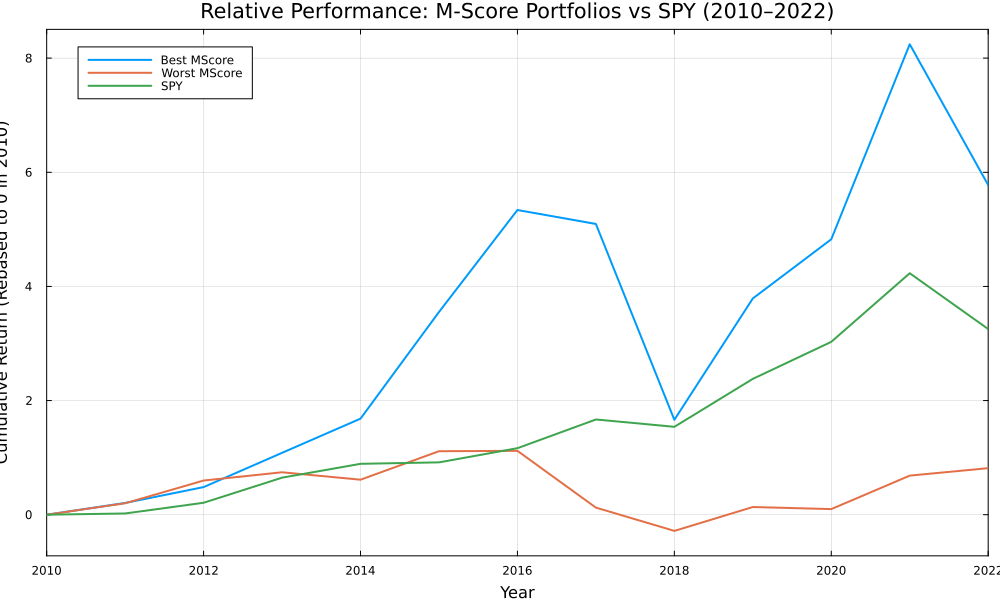

In [179]:
using Plots

# === Step 1: Rebase cumulative returns to start at 0 in 2010 ===
start_year = 2010
start_idx = findfirst(==(start_year), cumulative_df.Year)

# Get starting values for each portfolio
base_best = cumulative_df.Best[start_idx]
base_worst = cumulative_df.Worst[start_idx]
base_spy = cumulative_df.SPY[start_idx]

# Subtract base values to rebase series
rebased_best = cumulative_df.Best .- base_best
rebased_worst = cumulative_df.Worst .- base_worst
rebased_spy = cumulative_df.SPY .- base_spy

# === Step 2: Plot the rebased series ===
plot(
    cumulative_df.Year,
    [rebased_best rebased_worst rebased_spy],
    label = ["Best MScore" "Worst MScore" "SPY"],
    lw = 2,
    xlabel = "Year",
    ylabel = "Cumulative Return (Rebased to 0 in 2010)",
    title = "Relative Performance: M-Score Portfolios vs SPY (2010–2022)",
    legend = :topleft,
    framestyle = :box,
    xlim = (2010, 2022),
    size = (1000, 600)
)

In [169]:
# === Step 1: Filter portfolio data to 2001–2022 range ===
portfolio_data = innerjoin(returns, grouped[:, [:Ticker, :Year, :Avg_MScore]], on=[:Ticker, :Year])
portfolio_data = filter(:Year => y -> y in 2001:2022, portfolio_data)

# === Step 2: Initialize empty tracker DataFrame ===
portfolio_tracker = DataFrame(
    Year = Int[],
    Ticker = String[],
    Avg_MScore = Float64[],
    Portfolio = String[]
)

# === Step 3: Loop over years and tag best/worst firms ===
for y in 2001:2022
    sub = filter(:Year => ==(y), portfolio_data)

    if nrow(sub) < 5
        continue
    end

    sorted = sort(sub, :Avg_MScore)
    cut = max(1, Int(floor(0.2 * nrow(sorted))))

   # Top 20% = Best
    best_firms = sorted[1:cut, [:Ticker, :Avg_MScore]]
    best_firms[!, :Year] = fill(y, nrow(best_firms))
    best_firms[!, :Portfolio] = fill("Best", nrow(best_firms))

    # Bottom 20% = Worst
    worst_firms = sorted[end-cut+1:end, [:Ticker, :Avg_MScore]]
    worst_firms[!, :Year] = fill(y, nrow(worst_firms))
    worst_firms[!, :Portfolio] = fill("Worst", nrow(worst_firms))

    # Combine and append
    append!(portfolio_tracker, best_firms)
    append!(portfolio_tracker, worst_firms)
end

# === Reorder columns nicely ===
select!(portfolio_tracker, [:Year, :Ticker, :Avg_MScore, :Portfolio])

first(portfolio_tracker, 30)

Row,Year,Ticker,Avg_MScore,Portfolio
,Int64,String,Float64,String
1,2010,XOM,-2.59728,Best
2,2010,UNH,-2.35186,Worst
3,2011,XOM,-2.54756,Best
4,2011,COST,-2.44245,Worst
5,2012,GE,-2.50468,Best
6,2012,COST,-2.37152,Worst
7,2013,GE,-2.70742,Best
8,2013,AAPL,-2.23261,Worst
9,2014,NVDA,-7.61085,Best


**END OF NOTEBOOK**